In [1]:
# Cell 1: Load Results
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load all results
results_dir = Path("../outputs/results")
all_results = []

for result_file in results_dir.glob("*.json"):
    if result_file.name != "summary.json":
        with open(result_file) as f:
            all_results.append(json.load(f))

# Create DataFrame
df = pd.DataFrame([
    {
        "model": r["model"],
        "finetuned": r["finetuned"],
        "few_shot": r["few_shot"],
        "condition": r["condition"],
        "exact_match": r["metrics"]["exact_match"],
        "agent_f1": r["metrics"]["agent_f1"],
        "temporal_f1": r["metrics"]["temporal_f1"],
        "logical_f1": r["metrics"]["logical_f1"],
        "syntax_valid": r["metrics"]["syntax_valid"],
        "overall_score": r["metrics"]["overall_score"],
    }
    for r in all_results
])

print(df.to_string())

     model  finetuned  few_shot           condition  exact_match  agent_f1  temporal_f1  logical_f1  syntax_valid  overall_score
0  qwen-3b      False     False  baseline_zero_shot          0.0     0.075     0.463333    0.933333          0.50       0.438750
1  qwen-7b      False     False  baseline_zero_shot          0.0     0.225     0.608333    1.000000          0.95       0.623333
2  qwen-3b      False      True   baseline_few_shot          0.0     0.250     0.725000    1.000000          0.95       0.656250
3  qwen-7b      False      True   baseline_few_shot          0.1     0.225     0.841667    0.983333          1.00       0.705833


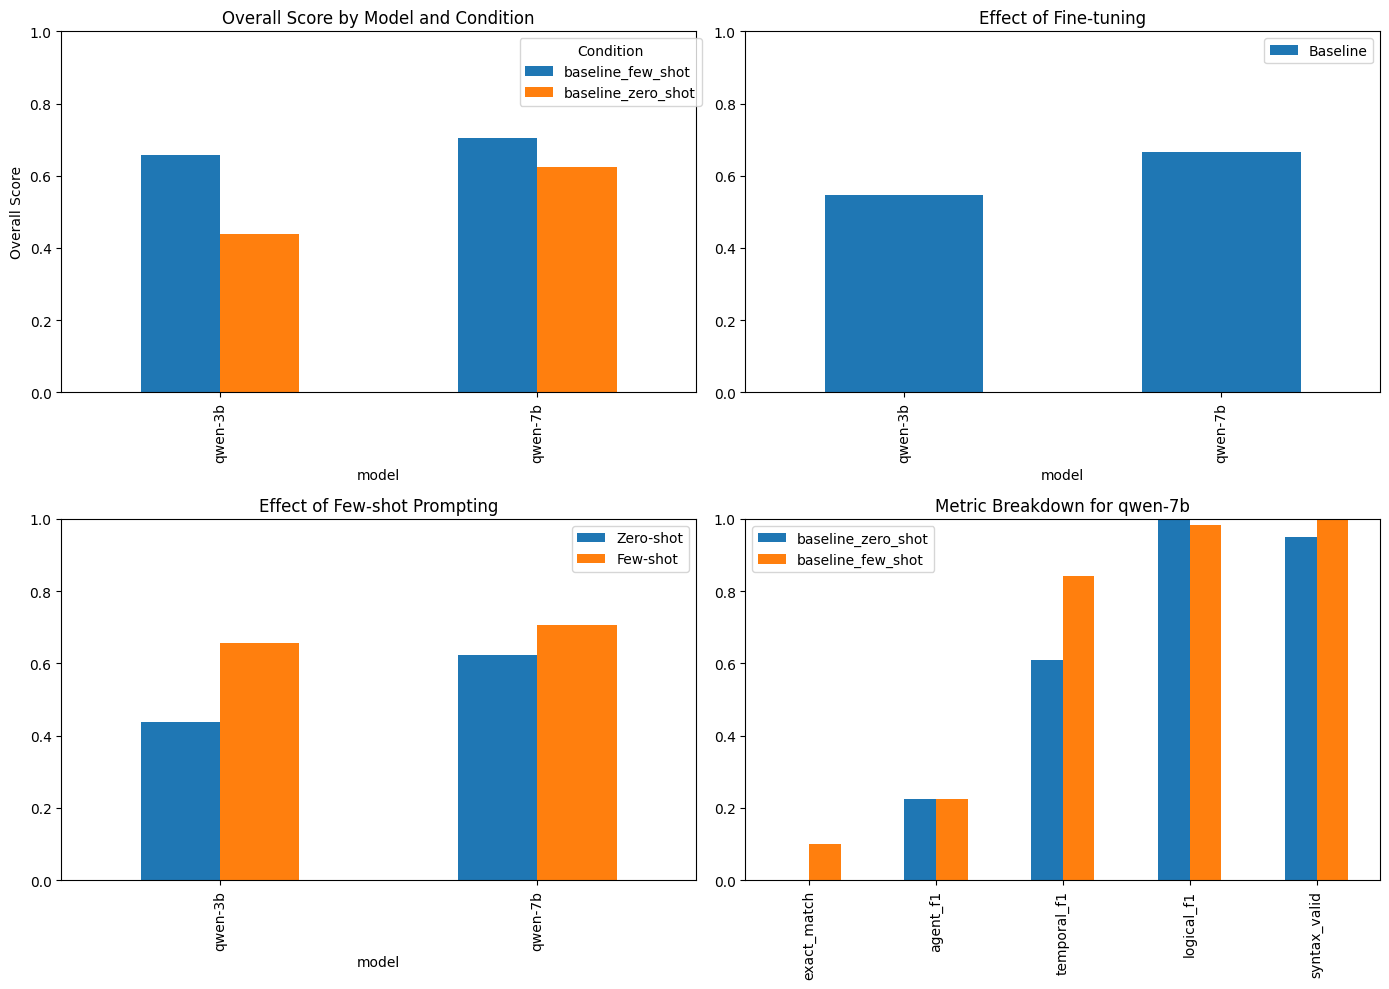

In [2]:
# Cell 2: Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall score by model and condition
ax1 = axes[0, 0]
pivot1 = df.pivot(index="model", columns="condition", values="overall_score")
pivot1.plot(kind="bar", ax=ax1)
ax1.set_title("Overall Score by Model and Condition")
ax1.set_ylabel("Overall Score")
ax1.legend(title="Condition", bbox_to_anchor=(1.02, 1))
ax1.set_ylim(0, 1)

# Plot 2: Effect of fine-tuning
ax2 = axes[0, 1]
ft_effect = df.groupby(["model", "finetuned"])["overall_score"].mean().unstack()
ft_effect.plot(kind="bar", ax=ax2)
ax2.set_title("Effect of Fine-tuning")
ax2.legend(["Baseline", "Fine-tuned"])
ax2.set_ylim(0, 1)

# Plot 3: Effect of few-shot
ax3 = axes[1, 0]
fs_effect = df.groupby(["model", "few_shot"])["overall_score"].mean().unstack()
fs_effect.plot(kind="bar", ax=ax3)
ax3.set_title("Effect of Few-shot Prompting")
ax3.legend(["Zero-shot", "Few-shot"])
ax3.set_ylim(0, 1)

# Plot 4: Metric breakdown for best model
ax4 = axes[1, 1]
best_model = df.loc[df["overall_score"].idxmax(), "model"]
best_data = df[df["model"] == best_model]
metrics = ["exact_match", "agent_f1", "temporal_f1", "logical_f1", "syntax_valid"]
best_data[metrics].T.plot(kind="bar", ax=ax4)
ax4.set_title(f"Metric Breakdown for {best_model}")
ax4.legend(best_data["condition"].values)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig("../outputs/results/comparison_plots.png", dpi=150)
plt.show()

In [3]:
# Cell 3: Statistical Summary
print("="*60)
print("STATISTICAL SUMMARY")
print("="*60)

# Best overall
best_idx = df["overall_score"].idxmax()
print(f"\n🏆 Best Configuration:")
print(f"   Model: {df.loc[best_idx, 'model']}")
print(f"   Condition: {df.loc[best_idx, 'condition']}")
print(f"   Overall Score: {df.loc[best_idx, 'overall_score']:.1%}")

# Effect sizes
print(f"\n📊 Effect of Fine-tuning:")
ft_base = df[~df["finetuned"]]["overall_score"].mean()
ft_tune = df[df["finetuned"]]["overall_score"].mean()
print(f"   Baseline: {ft_base:.1%}")
print(f"   Fine-tuned: {ft_tune:.1%}")
print(f"   Improvement: {ft_tune - ft_base:+.1%}")

print(f"\n📊 Effect of Few-shot:")
fs_zero = df[~df["few_shot"]]["overall_score"].mean()
fs_few = df[df["few_shot"]]["overall_score"].mean()
print(f"   Zero-shot: {fs_zero:.1%}")
print(f"   Few-shot: {fs_few:.1%}")
print(f"   Improvement: {fs_few - fs_zero:+.1%}")

# Model ranking
print(f"\n📊 Model Ranking (by avg overall score):")
ranking = df.groupby("model")["overall_score"].mean().sort_values(ascending=False)
for i, (model, score) in enumerate(ranking.items(), 1):
    print(f"   {i}. {model}: {score:.1%}")

STATISTICAL SUMMARY

🏆 Best Configuration:
   Model: qwen-7b
   Condition: baseline_few_shot
   Overall Score: 70.6%

📊 Effect of Fine-tuning:
   Baseline: 60.6%
   Fine-tuned: nan%
   Improvement: +nan%

📊 Effect of Few-shot:
   Zero-shot: 53.1%
   Few-shot: 68.1%
   Improvement: +15.0%

📊 Model Ranking (by avg overall score):
   1. qwen-7b: 66.5%
   2. qwen-3b: 54.7%
